In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import yfinance as yf
import pandas as pd
from scripts.utils import load_config
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scripts.generate_secondary_stocks import calculate_indicators

In [2]:
# Let's set up our config settings so we have what we need.
config_path = os.path.join(project_root, 'config', 'config.yaml')
config = load_config(config_path)

In [3]:
# Now let's bring in the data we need from our config file.
core_tickers = config['yfinance']['core_tickers']
start_date = config['yfinance']['start_date']
end_date = config['yfinance']['end_date']

In [4]:
# Now let's start to bring in the data we need with the variables we just created.
def core_tickers_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start = start, end = end)[["Close", "Volume"]].copy()
            
            stock_data = calculate_indicators(stock_data)
            
            data[ticker] = stock_data
        except Exception as e:
            print(f" Error downloading data for {ticker}: {e}")
    return data

def prep_time_series_df(data):
    df_list = []
    for ticker, df in data.items():
        df['Ticker'] = ticker
        df_list.append(df)
    combined_df = pd.concat(df_list)
    combined_df.reset_index(inplace=True)
    return combined_df

def check_missing_vals(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data

core_data = core_tickers_data(core_tickers, start_date, end_date)

df = prep_time_series_df(core_data)

df['Date'] = pd.to_datetime(df['Date'])


df_missing = check_missing_vals(df)
print("Missing values before filling methods:", df_missing)

# We have some missing values we need to address here.  Let's take a look.
df.head(15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Missing values before filling methods: SMA    294
RSI      6
dtype: int64


,Date,Close,Volume,SMA,EMA,RSI,Ticker
0,2019-01-02,39.480000,148158800,NaN,39.480000,NaN,AAPL
1,2019-01-03,35.547501,365248800,NaN,39.325784,0.000000,AAPL
2,2019-01-04,37.064999,234428400,NaN,39.237126,-62.836333,AAPL
3,2019-01-07,36.982498,219111200,NaN,39.148709,-60.760648,AAPL
4,2019-01-08,37.687500,164101200,NaN,39.091407,-123.988866,AAPL
5,2019-01-09,38.327499,180396400,NaN,39.061449,-248.373003,AAPL
6,2019-01-10,38.450001,143122800,NaN,39.037471,-289.806228,AAPL
7,2019-01-11,38.072498,108092800,NaN,38.999629,-212.078012,AAPL
8,2019-01-14,37.500000,129756800,NaN,38.940820,-150.757641,AAPL
9,2019-01-15,38.267502,114843600,NaN,38.914415,-309.485322,AAPL


In [5]:
# Let's start to examine our missing values more closely.  Looks like we can easily impute the RSI data, that's not an issue.  The SMA on the other hand needs a closer look.
print(df_missing)

SMA    294
RSI      6
dtype: int64


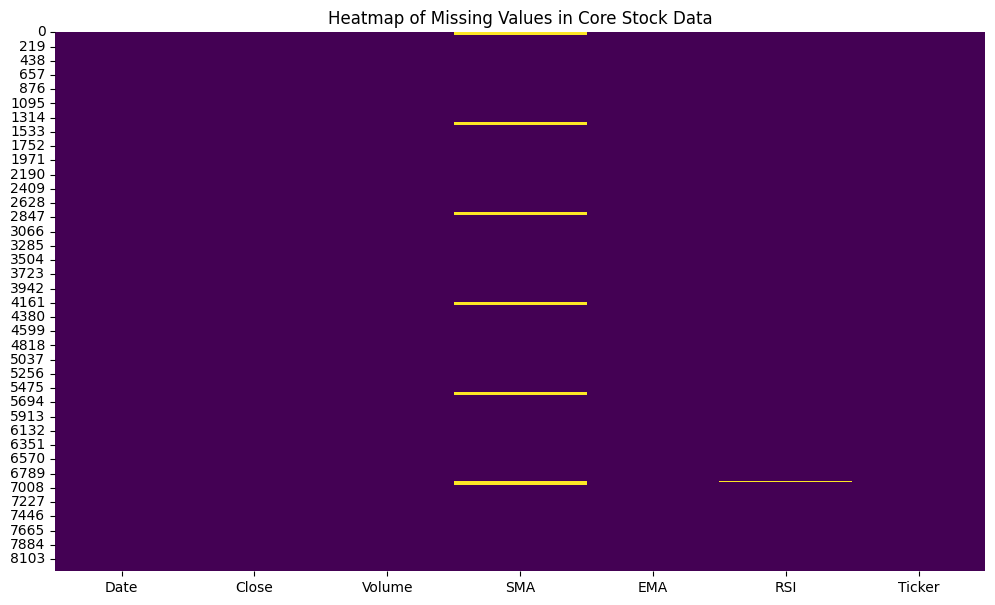

In [6]:
# Let's look at the location of those missing values and see if we can see if/how they are grouped.
plt.figure(figsize = (12,7))
sns.heatmap(df.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

#### Looking at the above you can see that there are just a few values for the RSI column.  These we will impute with surrounding values.  For the SMA however it isn't as straightforward.  We look to be missing the first 49 rows of our dataset.  If we tried something like fill with forwardfill or backfill it wouldn't work or be really inaccurate as we don't have a starting data point to go off of.  The gap in data points is likely due to our window size and because SMA requires a full window to calculate.  Due to this we will just drop those first rows so we can start with a new window for our data and then proceed with interpolating and imputing the rest. 

In [7]:
# Let's first remove that beginning chunk of rows with the SMA na values.
df = df.iloc[49:].reset_index(drop = True)
print(df.head())

        Date      Close     Volume       SMA        EMA         RSI Ticker
0 2019-03-14  45.932499   94318000  41.35925  42.219051  147.119051   AAPL
1 2019-03-15  46.529999  156171600  41.50025  42.388107  142.640938   AAPL
2 2019-03-18  47.005001  104879200  41.72940  42.569162  137.034379   AAPL
3 2019-03-19  46.632500  126585600  41.92075  42.728509  156.260813   AAPL
4 2019-03-20  47.040001  124140800  42.12190  42.897587  132.245226   AAPL


In [8]:
# Let's make a quick function for our imputation and interpolation, we may need this again.
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

df['SMA'] = fill_missing_vals(df['SMA'])
df['RSI'] = fill_missing_vals(df['RSI'])

print(df.isna().sum())

Date      0
Close     0
Volume    0
SMA       0
EMA       0
RSI       0
Ticker    0
dtype: int64


In [9]:
# So far so good.  Now let's start to set up and read in our exogenous data.
def dl_exogenous_data(start, end, exo_tickers):
    exo_data = {}
    for name, ticker in exo_tickers.items():
        try:
            data = yf.download(ticker, start = start, end = end)
            exo_data[name] = data['Close']
        except Exception as e:
            print(f"Error downloading data for {name} ({ticker}): {e}")
    exo_df = pd.DataFrame(exo_data)
    exo_df.reset_index(inplace=True)
    return exo_df

exo_tickers = config['yfinance']['exogenous_tickers']
exo_df = dl_exogenous_data(start_date, end_date, exo_tickers)

# Let's make sure our Date column is converted to datetime format to be used when we merge our dataframes for time series.
exo_df['Date'] = pd.to_datetime(exo_df['Date'])





# Let's take a quick look at the output.
print(exo_df.shape)
print(exo_df.describe())
exo_df.sample(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(1434, 19)
                                Date  interest_rates_10yr         gold  \
count                           1434          1382.000000  1383.000000   
mean   2021-09-29 16:47:11.799163136             2.454483  1782.809108   
min              2019-01-01 00:00:00             0.499000  1269.300049   
25%              2020-05-15 18:00:00             1.481000  1671.250000   
50%              2021-09-29 12:00:00             2.092500  1810.000000   
75%              2023-02-13 18:00:00             3.696500  1927.500000   
max              2024-06-28 00:00:00             4.988000  2433.899902   
std                              NaN             1.269550   241.226075   

            copper     platinum       silver    crude_oil  natural_gas  \
count  1383.000000  1371.000000  1382.000000  1383.000000  1383.000000   
mean      3.586526   952.038875    21.837412    68.269834     3.398328   
min       2.119500   595.900024    11.735000   -37.630001     1.482000   
25%       2.876750   884.3

,Date,interest_rates_10yr,gold,copper,platinum,silver,crude_oil,natural_gas,corn,wheat,volatility_index,exchange_rate_usd_eur,exchange_rate_usd_jpy,sp500,nasdaq_100,dow_jones_industrial_average,consumer_confidence_index,vanguard_total_world_stock_etf,us_treasury_bond_etf
26,2019-02-06,2.702,1309.500000,2.8355,809.799988,15.656000,54.009998,2.662,380.00,526.00,15.380000,1.140993,109.941002,2731.610107,6997.620117,25390.300781,117.360001,71.260002,24.790001
1219,2023-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.077586,146.057007,NaN,NaN,NaN,NaN,NaN,NaN
170,2019-08-27,1.490,1541.000000,2.5435,865.400024,18.139000,54.930000,2.202,357.00,473.75,20.309999,1.110371,105.977997,2869.159912,7566.029785,25777.900391,146.070007,72.269997,26.620001
208,2019-10-18,1.747,1488.199951,2.6250,892.299988,17.502001,53.779999,2.320,391.00,532.25,14.250000,1.112718,108.581001,2986.199951,7868.490234,26770.199219,144.059998,75.570000,26.190001
1200,2023-08-08,4.026,1924.099976,3.7480,897.900024,22.716999,82.919998,2.777,485.75,656.25,15.990000,1.100316,142.524002,4499.379883,15273.049805,35314.488281,104.040001,98.029999,22.639999
1151,2023-05-31,3.637,1963.900024,3.6310,1007.099976,23.474001,68.089996,2.266,594.00,594.25,17.940001,1.073307,139.792007,4179.830078,14254.089844,32908.269531,113.209999,92.269997,23.139999
1238,2023-09-29,4.573,1848.099976,3.7260,906.799988,22.236000,90.790001,2.929,476.75,541.50,17.520000,1.056245,149.337006,4288.049805,14715.240234,33507.500000,92.029999,93.180000,22.040001
875,2022-05-10,2.993,1839.900024,4.1545,953.500000,21.389999,99.760002,7.385,786.50,1083.25,32.990002,1.056580,130.376999,4001.050049,12345.860352,32160.740234,170.289993,89.199997,24.000000
568,2021-03-05,1.554,1698.000000,4.0870,1127.099976,25.257000,66.089996,2.701,562.00,654.00,24.660000,1.196774,107.955002,3841.939941,12668.509766,31496.300781,150.149994,95.339996,26.360001
526,2021-01-06,1.042,1906.900024,3.6500,1105.699951,26.973000,50.630001,2.716,495.00,647.50,25.070000,1.230027,102.678001,3748.139893,12623.349609,30829.400391,151.429993,93.720001,27.160000


In [10]:
# Just looking at the sample readout we can see we have at least one row of missing values, time to investigate!
exo_df_missing = check_missing_vals(exo_df)
print(exo_df_missing)


interest_rates_10yr               52
gold                              51
copper                            51
platinum                          63
silver                            52
crude_oil                         51
natural_gas                       51
corn                              52
wheat                             52
volatility_index                  52
exchange_rate_usd_eur              1
exchange_rate_usd_jpy              1
sp500                             52
nasdaq_100                        52
dow_jones_industrial_average      52
consumer_confidence_index         52
vanguard_total_world_stock_etf    52
us_treasury_bond_etf              52
dtype: int64


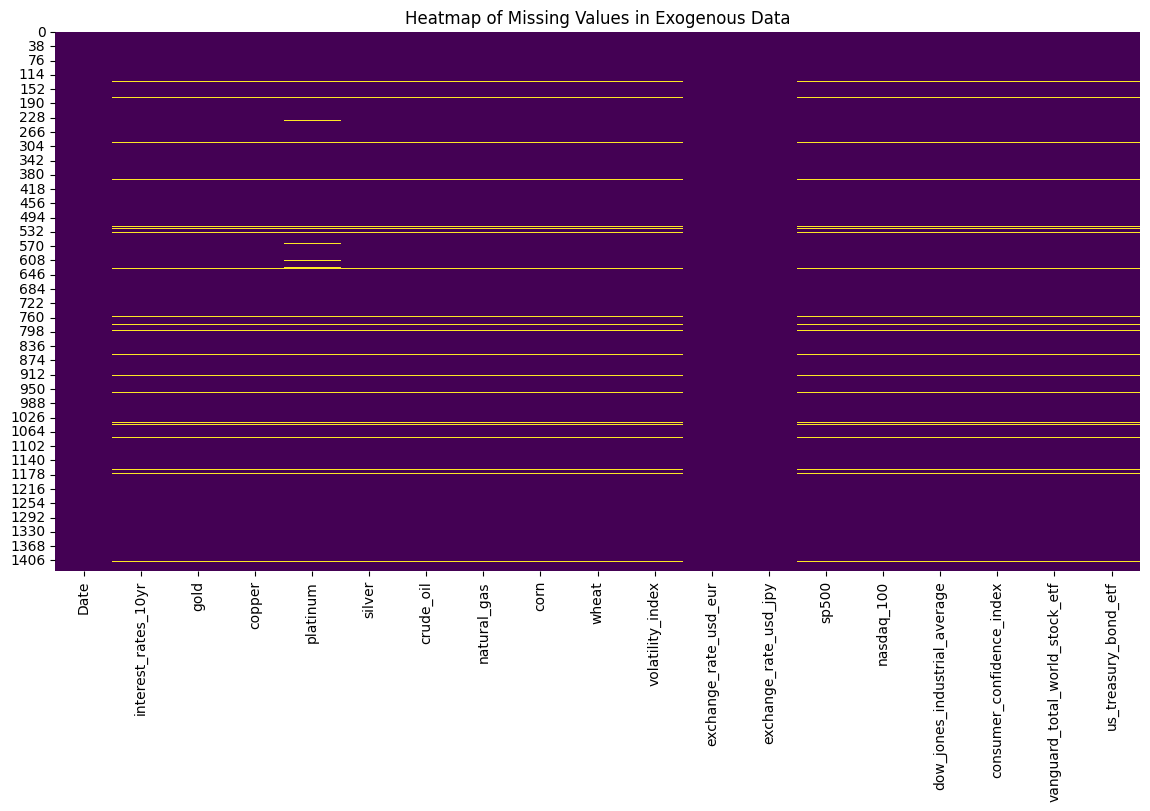

In [11]:
# Looks like mostly 52 rows, upwards of 63 for platinum. Before we address filling the missing values let's look a little closer at the missing values themselves with a heatmap and a correlation matrix.
plt.figure(figsize = (14,7))
sns.heatmap(exo_df.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Exogenous Data')
plt.show()

#### Above you can see that our missing values are held constant across all rows and features, save for the platinum column that has a few more missing columns.  This will make it easier for us to impute our values.

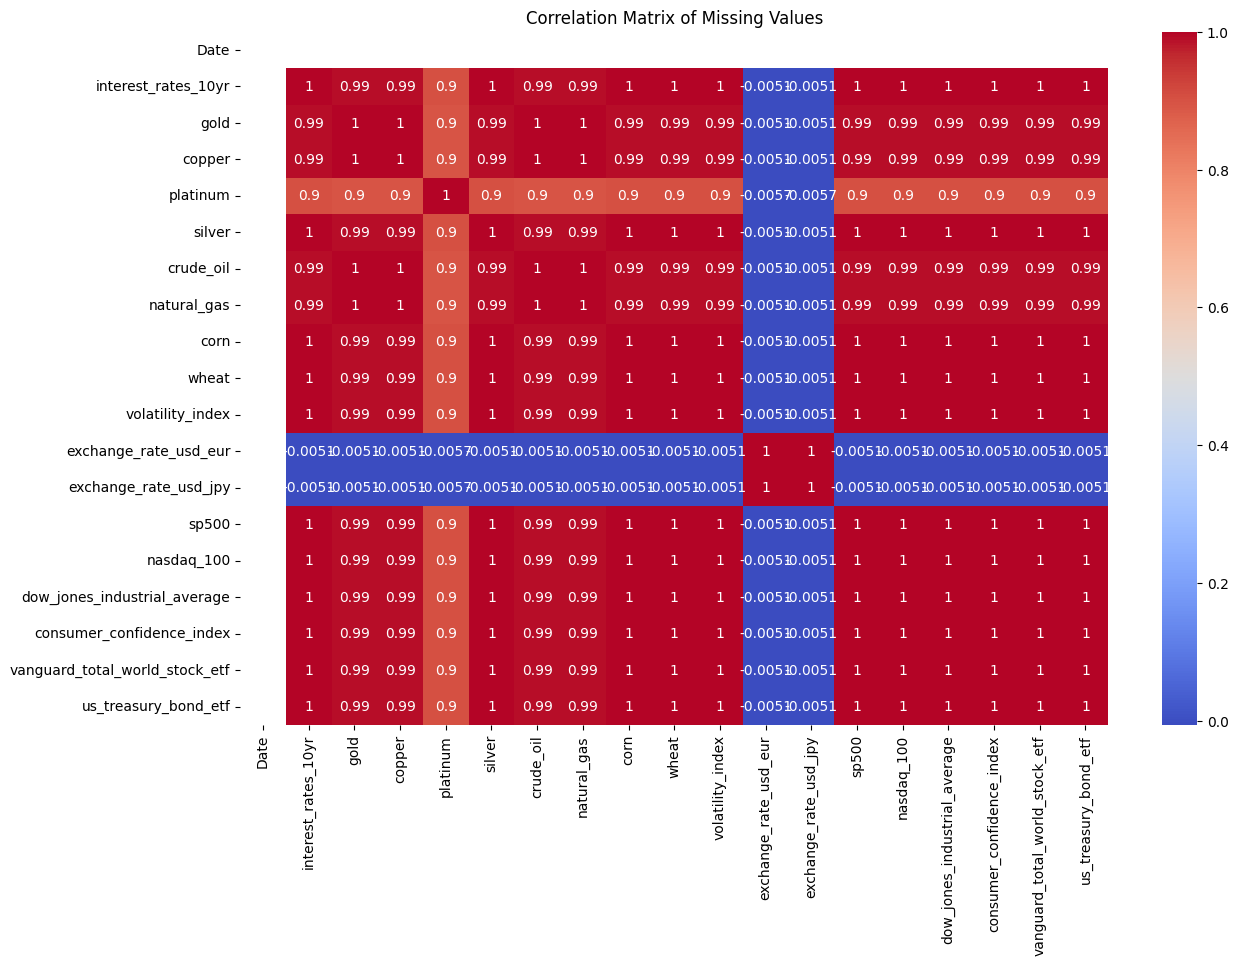

In [12]:
# Now let's plot the correlation matrix to see the relationship between missing values and their corresponding features.
na_df = exo_df.isna().astype(int)
plt.figure(figsize = (14,9))
sns.heatmap(na_df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Missing Values')
plt.show()

#### What we can take from the above plot is that the commodities (gold, silver, copper, etc.) are all highly correlated, meaning when one of those features has a missing value there is a high likelihood (over 90%) that another commodity will also be missing data for that date.  We can also see that the exchange rate data is showing very low correlation relationship, pretty much negative in fact for all relationships (aside from each other).  

In [13]:
# Now that we have properly identified and reviewed the missing values, let's go ahead and fill them, then check again to make sure all values are accounted for.
exo_df = fill_missing_vals(exo_df)

print(exo_df.isna().sum())

Date                              0
interest_rates_10yr               0
gold                              0
copper                            0
platinum                          0
silver                            0
crude_oil                         0
natural_gas                       0
corn                              0
wheat                             0
volatility_index                  0
exchange_rate_usd_eur             0
exchange_rate_usd_jpy             0
sp500                             0
nasdaq_100                        0
dow_jones_industrial_average      0
consumer_confidence_index         0
vanguard_total_world_stock_etf    0
us_treasury_bond_etf              0
dtype: int64


In [14]:
# Great, let's save this data to another csv file for quick reference if we should need it.
df.to_csv(os.path.join(project_root, 'data', 'core_stock_data.csv'), index = True)

exo_df.to_csv(os.path.join(project_root, 'data', 'exogenous_data.csv'), index = True)